In [1]:
import pandas as pd
import os
import statsmodels.stats.multitest as multi
import numpy as np

In [2]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from matplotlib.pyplot import cm

## Get Interaction data

In [4]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [5]:
def fdr(df,P):
    probabilities = df[P].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh" ,
                is_sorted=False,
            )
    discoveries = report[1]
    
    return(discoveries)

## get association file

In [6]:
assoc=pd.read_csv("../tables/time-germline.csv",delimiter="\t")
assoc["assoc"]=assoc["snps"]+"_"+assoc["file"]
assoc["snp_assoc"]=assoc["proxy_snp"]+"_"+assoc["file"]

### run xcell-ieqt.sh

### run compiled-xcell-ieqtl.sh

In [7]:
age=pd.read_csv("../data/x-cell-interaction/results/xcell.age.csv")
age_filt=age[["pheno","ID","P"]]
age_filt.columns=["file","snps","ADDxage"]
age_filt["file"]=age_filt["file"].str.replace(".","-")
age_filt=pd.merge(assoc,age_filt,on=["file","snps"],how="left")
age_filt=age_filt[~age_filt["ADDxage"].isnull()]
age_filt["fdr age"]=fdr(age_filt,"ADDxage")

<ipython-input-7-0d18d0436956>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  age_filt["file"]=age_filt["file"].str.replace(".","-")
<ipython-input-7-0d18d0436956>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_filt["file"]=age_filt["file"].str.replace(".","-")


In [8]:
age_interact_sig=age_filt[age_filt["fdr age"]<.1]

In [9]:
sex=pd.read_csv("../data/x-cell-interaction/results/xcell.sex.csv",delimiter="\t")
sex_filt=age[["pheno","ID","P"]]
sex_filt.columns=["file","snps","ADDxsex"]
sex_filt["file"]=sex_filt["file"].str.replace(".","-")
sex_filt=pd.merge(assoc,sex_filt,on=["file","snps"],how="left")
sex_filt=sex_filt[~sex_filt["ADDxsex"].isnull()]
sex_filt["fdr sex"]=fdr(sex_filt,"ADDxsex")

<ipython-input-9-fd17e44f7624>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sex_filt["file"]=sex_filt["file"].str.replace(".","-")
<ipython-input-9-fd17e44f7624>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sex_filt["file"]=sex_filt["file"].str.replace(".","-")


In [10]:
sex_interact_sig=sex_filt[sex_filt["fdr sex"]<.1]

## Cell interaction

In [11]:
cell=pd.read_csv("../data/x-cell-interaction/results/xcell.cell.csv",delimiter=",")
cell["pheno"]=cell["pheno"].str.replace(".","-")
cell["assoc"]=cell["ID"]+"_"+cell["pheno"]
cell_interact=cell.pivot_table(index="assoc",columns="TEST",values="P")
cell_interact=cell_interact.reset_index()
df_cell_interact=pd.merge(assoc,cell_interact,on="assoc",how="left")
cols=[x for x in df_cell_interact.columns if "ADD" in x]
    
cell_filt=pd.DataFrame()

for x in cols:
    df_cell_interact=df_cell_interact[~df_cell_interact[x].isnull()]
    df_cell_interact["fdr "+x]=fdr(df_cell_interact,x)
    df_cell=df_cell_interact[["assoc",x,"fdr "+x]]
    df_cell["cell"]=x
    df_cell.columns=["assoc","coef","fdr","cell"]
    cell_filt=cell_filt.append(df_cell)

<ipython-input-11-ec3c2a268e56>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cell["pheno"]=cell["pheno"].str.replace(".","-")
<ipython-input-11-ec3c2a268e56>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cell["cell"]=x


In [12]:
#df_cell_interact.to_csv("../data/supplemental/Supplemental_Table_10.csv",index=None)

In [13]:
cell_interact_sig=cell_filt[cell_filt["fdr"]<.05]
cell_interact_sig["snps"]=cell_interact_sig["assoc"].str.split("_").str[0]
cell_interact_sig["cell"]=cell_interact_sig["cell"].str.split("x").str[1]
cell_interact_sig["pheno"]=cell_interact_sig["assoc"].str.split("_").str[1]

<ipython-input-13-bbf08940c673>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_interact_sig["snps"]=cell_interact_sig["assoc"].str.split("_").str[0]
<ipython-input-13-bbf08940c673>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_interact_sig["cell"]=cell_interact_sig["cell"].str.split("x").str[1]
<ipython-input-13-bbf08940c673>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [14]:
"{} associations have cell interactions".format(len(cell_interact_sig["assoc"].unique()))

'32 associations have cell interactions'

In [15]:
xcell_annot=pd.read_excel("../data/x-cell-interaction/results/13059_2017_1349_MOESM1_ESM.xlsx")

xcell_annot["Cell types"]=xcell_annot["Cell types"].str.replace(" ",".")
xcell_annot["Cell types"]=xcell_annot["Cell types"].str.replace("+",".")
xcell_annot["Cell types"]=xcell_annot["Cell types"].str.replace("-",".")
xcell_annot["Cell types"]=xcell_annot["Cell types"].replace({"Smooth.muscle.cells":"Smooth.muscle","Smooth.muscle.cells":"Smooth.muscle","Skeletal.muscle.cells":"Skeletal.muscle"})
xcell_annot["Full name"]=xcell_annot["Full name"].replace({"Macrophages M2":"Macrophages","Macrophages M1":"Macrophages","Activated dendritic cells":"Dendritic cells","Plasmacytoid dendritic cells":"Dendritic cells","Immature dendritic cells":"Dendritic cells","Xonventional dendritic cells":"Dendritic cells","CD8+ central memory T-cells":"CD8+ T cells","CD4+ memory T-cells":"CD4+ T cells","CD4+ effector memory T-cells":"CD4+ T cells"})

mp_name=dict(zip(xcell_annot["Cell types"],xcell_annot["Full name"]))
mp_annot=dict(zip(xcell_annot["Full name"],xcell_annot["Subgroup"])) 

cell_interact_sig["name"]=cell_interact_sig["cell"].map(mp_name)
cell_interact_sig["group"]=cell_interact_sig["name"].map(mp_annot)

/cellar/users/mpagadal/Programs/miniconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
<ipython-input-15-c1de9f5bb86b>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  xcell_annot["Cell types"]=xcell_annot["Cell types"].str.replace("+",".")
<ipython-input-15-c1de9f5bb86b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_interact_sig["name"]=cell_interact_sig["cell"].map(mp_name)
<ipython-input-15-c1de9f5bb86b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [16]:
mp_assoc=dict(zip(assoc["assoc"],assoc["snp_assoc"]))

In [17]:
cell_interact_sig["assoc"]=cell_interact_sig["assoc"].map(mp_assoc)
cell_interact_sig.head()

<ipython-input-17-6a1818fb1773>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_interact_sig["assoc"]=cell_interact_sig["assoc"].map(mp_assoc)


,assoc,coef,fdr,cell,snps,pheno,name,group
861,rs9272546_HLA-DQA2,0.000016,0.007393,B.cells,6:32606941:C:T,HLA-DQA2,B-cells,Lymphoid
442,rs2927610_ERAP2,0.000106,0.026566,CD4..memory.T.cells,5:96200770:T:A,ERAP2,CD4+ T cells,Lymphoid
444,rs2549781_ERAP2,0.000115,0.026566,CD4..memory.T.cells,5:96230122:T:G,ERAP2,CD4+ T cells,Lymphoid
863,rs3134996_HLA-DQA2,0.000248,0.038166,CD4..memory.T.cells,6:32636866:T:A,HLA-DQA2,CD4+ T cells,Lymphoid
165,rs28040_ERAP1,0.000693,0.045627,CD8..Tcm,5:96018066:C:G,ERAP1,CD8+ T cells,Lymphoid


## DICE interaction

In [18]:
dice_dir="../data/dice/"
dice_df=pd.DataFrame()

for x in [x for x in os.listdir(dice_dir) if ".txt" in x]:
    print(x)
    dice=pd.read_csv(dice_dir+x,delimiter="\t",header=None)
    dice["cell"]=x.split(".")[0]
    dice_df=dice_df.append(dice)
dice_df["Gene"]=dice_df[7].str.split("GeneSymbol=").str[1]
dice_df["Gene"]=dice_df["Gene"].str.split(";").str[0]
dice_df["assoc"]=dice_df[2]+"_"+dice_df["Gene"]

M2.snps.txt
THSTAR.snps.txt
CD4_NAIVE.snps.txt
TH17.snps.txt
TREG_MEM.snps.txt
CD8_NAIVE.snps.txt
TH1.snps.txt
TREG_NAIVE.snps.txt
NK.snps.txt
TH2.snps.txt
CD4_STIM.snps.txt
B_CELL_NAIVE.snps.txt
TFH.snps.txt
CD8_STIM.snps.txt
MONOCYTES.snps.txt


In [19]:
dice_df=dice_df[dice_df["assoc"].isin(assoc["snp_assoc"].tolist())]

In [20]:
dice_cell={"MONOCYTES":"Monocytes","M2":"Macrophages","TREG_NAIVE":"CD4+ T cells","CD4_NAIVE":"CD4+ T cells","TREG_MEM":"CD4+ T cells","TH17":"CD4+ T cells","CD8_NAIVE":"CD8+ T cells","B_CELL_NAIVE":"B-cells","CD4_STIM":"CD4+ T cells","CD8_STIM":"CD8+ T cells","TH2":"CD4+ T cells","TFH":"CD4+ T cells","TH1":"CD4+ T cells","THSTAR":"CD4+ T cells","NK":"NK"}
dice_df["cell"]=dice_df["cell"].map(dice_cell)

### Get overall assoc

In [21]:
ieqtl_counts=cell_interact_sig[["assoc","cell"]].drop_duplicates()
ieqtl_counts.columns=["assoc","cell"]
dice_counts=dice_df[["assoc","cell"]].drop_duplicates()
ieqtl_counts["type"]="ieqtl"
dice_counts["type"]="dice"
dice_ieqtl_counts=ieqtl_counts.append(dice_counts)

In [23]:
cell_map={"Macrophages.M1":"Macrophages","Macrophages.M2":"Macrophages","DC":"DC",
          "B.cells.memory":"B-cells","Dendritic.cells.activated":"Dendritic Cells",
          "NK.cells.resting":"NK","T.cells.CD4.memory.activated":"CD4+ T cells",
          "T.cells.CD4.memory.resting":"CD4+ T cells","T.cells.CD4.naive":"CD4+ T cells",
          "T.cells.CD8":"CD8+ T cells","T.cells.follicular.helper":"CD4+ T cells",
          "Eosinophils":"Eosinophils","Macrophages":"Macrophages","Monocytes":"Monocytes",
          "NK":"NK","CD4+ T cells":"CD4+ T cells","CD8+ T cells":"CD8+ T cells",
          "B-cells":"B-cells","CD8..T.cells":"CD8+ T cells","CD8..Tcm":"CD8+ T cells",
         "CD4..memory.T.cells":"CD4+ T cells","CD4..naive.T.cells":"CD4+ T cells","Tgd.cells":"Tgd.cells","B.cells":"B-cells","CD4..Tem":"CD4+ T cells","Memory.B.cells":"B-cells","CD8..Tem":"CD8+ T cells","CD4..T.cells":"CD4+ T cells","CD8..T.cells":"CD8+ T cells"}

dice_ieqtl_counts["cell"]=dice_ieqtl_counts["cell"].map(cell_map)

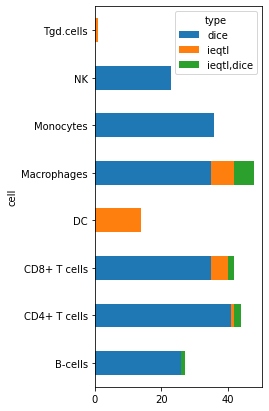

In [24]:
dice_ieqtl_counts["comb"]=dice_ieqtl_counts["assoc"]+dice_ieqtl_counts["cell"]+dice_ieqtl_counts["type"]
dice_ieqtl_counts=dice_ieqtl_counts.drop_duplicates(subset="comb")
total_dice_ieqtl_counts=dice_ieqtl_counts.groupby(['assoc','cell'])['type'].apply(lambda x: ','.join(x)).reset_index()
total_dice_ieqtl_counts=total_dice_ieqtl_counts.groupby(["cell","type"]).size().reset_index()
df_bar=total_dice_ieqtl_counts.pivot(index="cell",columns="type",values=0).fillna(0)
plt=df_bar.plot.barh(stacked=True, figsize = (3,7))
#plt.figure.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig3/LASSO_total.ieqtl.pdf",bbox_inches='tight')

In [25]:
dice_ieqtl_counts["snp"]=dice_ieqtl_counts["assoc"].str.split("_").str[0]
dice_ieqtl_counts[["snp","cell"]].drop_duplicates()["cell"].value_counts()

Macrophages     48
CD4+ T cells    44
CD8+ T cells    42
Monocytes       36
B-cells         27
NK              23
DC              14
Tgd.cells        1
Name: cell, dtype: int64